In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import os

from torchvision import datasets, transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

vae_latent_dim = 31
vae_epochs = 25
vae_batch_size = 128
vae_lr = 1e-3

Using device: cuda


In [3]:
import gdown
import zipfile

os.makedirs("celeba_gan", exist_ok=True)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with zipfile.ZipFile(output, "r") as zipobj:
        zipobj.extractall("celeba_gan")

In [ ]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1]
])


from torchvision.datasets import ImageFolder
dataset = ImageFolder(root="celeba_gan", transform=transform)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


train_loader_vae = DataLoader(train_dataset, batch_size=vae_batch_size, shuffle=True)
test_loader_vae = DataLoader(test_dataset, batch_size=vae_batch_size, shuffle=False)


print("Train size:", len(train_dataset), "Test size:", len(test_dataset))


Train size: 182339 Test size: 20260


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_channels=16):
        """
        Args:
            latent_channels: Number of channels in the latent space.
        """
        super().__init__()
        self.latent_channels = latent_channels

        # -------- Encoder: 3x64x64 → latent_channelsx8x8 --------
        self.enc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), 
            nn.SiLU(inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1), 
            nn.SiLU(inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1), 
            nn.SiLU(inplace=True),

            nn.Conv2d(256, 512, 3, 1, 1), 
            nn.SiLU(inplace=True),
        )

        self.conv_mu     = nn.Conv2d(512, latent_channels, 3, padding=1)
        self.conv_logvar = nn.Conv2d(512, latent_channels, 3, padding=1)

        # -------- Decoder: latent_channelsx8x8 → 3x64x64 --------
        self.dec = nn.Sequential(
            nn.Conv2d(latent_channels, 512, 3, padding=1),
            nn.SiLU(inplace=True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1), 
            nn.SiLU(inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1), 
            nn.SiLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
            nn.SiLU(inplace=True),

            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh(),
        )

    def encode(self, x):
        h = self.enc(x)
        mu = self.conv_mu(h)
        logvar = self.conv_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

    @torch.no_grad()
    def encode_to_2d_latent(self, x):
        mu, _ = self.encode(x)
        return mu

    def decode_from_2d_latent(self, z):
        return self.decode(z)

In [6]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction="sum") / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl, recon_loss, kl


In [ ]:
vae = VAE().to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=vae_lr)

print(vae)

VAE(
  (enc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): SiLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): SiLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): SiLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): SiLU(inplace=True)
  )
  (conv_mu): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_logvar): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec): Sequential(
    (0): Conv2d(16, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): SiLU(inplace=True)
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): SiLU(inplace=True)
    (6): ConvTranspose2d(128, 64, ker

In [ ]:
vae.train()
save_every = 5
save_dir = "checkpoints_vae"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(1, vae_epochs + 1):
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    n_samples = 0

    for x, _ in train_loader_vae:
        x = x.to(device)

        vae_optimizer.zero_grad()

        x_recon, mu, logvar = vae(x)
        loss, recon_loss, kl_loss = vae_loss(x_recon, x, mu, logvar)

        loss.backward()
        vae_optimizer.step()

        batch_size = x.size(0)
        total_loss  += loss.item() * batch_size
        total_recon += recon_loss.item() * batch_size
        total_kl    += kl_loss.item() * batch_size
        n_samples   += batch_size

    avg_loss  = total_loss / n_samples
    avg_recon = total_recon / n_samples
    avg_kl    = total_kl / n_samples

    print(
        f"[VAE] Epoch {epoch:02d} | "
        f"Loss: {avg_loss:.4f} "
        f"(Recon {avg_recon:.4f}, KL {avg_kl:.4f})"
    )
    if epoch % save_every == 0:
        ckpt_path = os.path.join(save_dir, f"vae_epoch_{epoch:03d}.pt")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": vae.state_dict(),
                "optimizer_state_dict": vae_optimizer.state_dict(),
                "avg_loss": avg_loss,
            },
            ckpt_path,
        )
        print(f"Saved: {ckpt_path}")

[VAE] Epoch 01 | Loss: 626.6081 (Recon 412.6412, KL 213.9670)
[VAE] Epoch 02 | Loss: 501.4444 (Recon 282.7384, KL 218.7060)
[VAE] Epoch 03 | Loss: 485.0994 (Recon 269.1201, KL 215.9793)
[VAE] Epoch 04 | Loss: 476.1830 (Recon 262.3485, KL 213.8345)
[VAE] Epoch 05 | Loss: 470.0687 (Recon 257.9514, KL 212.1173)
Saved: checkpoints_vae/vae_epoch_005.pt
[VAE] Epoch 06 | Loss: 465.3690 (Recon 254.6747, KL 210.6944)
[VAE] Epoch 07 | Loss: 461.8382 (Recon 252.3968, KL 209.4413)
[VAE] Epoch 08 | Loss: 459.1360 (Recon 250.6968, KL 208.4392)
[VAE] Epoch 09 | Loss: 456.6457 (Recon 249.0885, KL 207.5573)
[VAE] Epoch 10 | Loss: 454.9058 (Recon 247.9776, KL 206.9281)
Saved: checkpoints_vae/vae_epoch_010.pt
[VAE] Epoch 11 | Loss: 453.4011 (Recon 246.9798, KL 206.4213)
[VAE] Epoch 12 | Loss: 452.2345 (Recon 246.2574, KL 205.9771)
[VAE] Epoch 13 | Loss: 450.9068 (Recon 245.3388, KL 205.5680)
[VAE] Epoch 14 | Loss: 450.1008 (Recon 244.8129, KL 205.2879)
[VAE] Epoch 15 | Loss: 449.1010 (Recon 244.0839, KL 

## Reconstruction

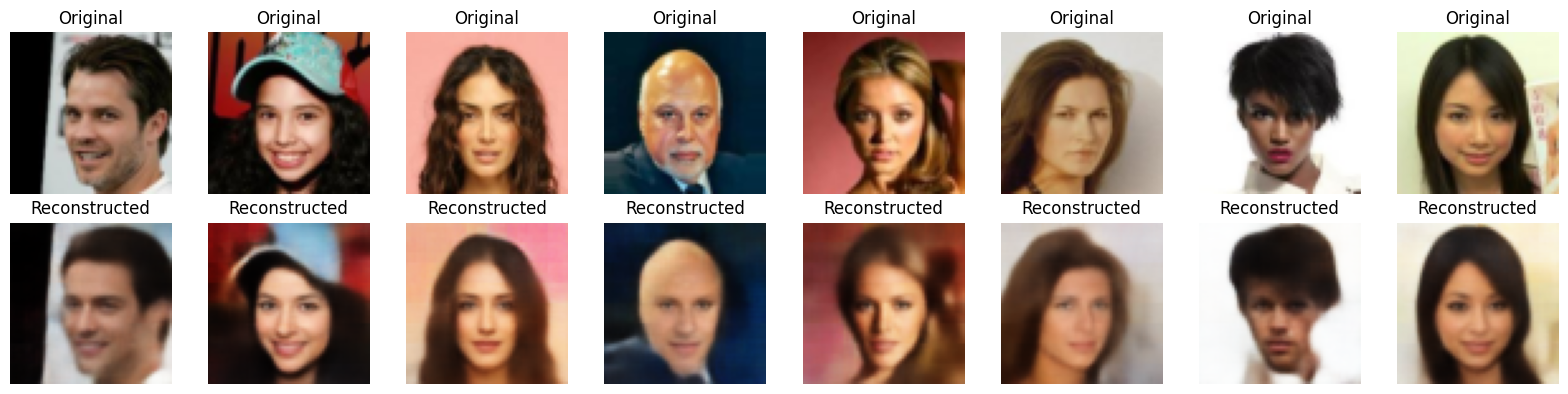

In [ ]:
vae.eval()
x_batch, _ = next(iter(test_loader_vae))  
x_batch = x_batch.to(device)

with torch.no_grad():
    x_hat, mu, logvar = vae(x_batch)

x_batch = x_batch.cpu()
x_hat = x_hat.cpu()

x_batch = (x_batch + 1) / 2
x_hat = (x_hat + 1) / 2

n = 8
plt.figure(figsize=(2 * n, 4))

for i in range(n):

    plt.subplot(2, n, i + 1)
    plt.imshow(x_batch[i].permute(1, 2, 0))  
    plt.axis("off")
    plt.title("Original")

    plt.subplot(2, n, n + i + 1)
    plt.imshow(x_hat[i].permute(1, 2, 0))
    plt.axis("off")
    plt.title("Reconstructed")

plt.tight_layout()
plt.show()


In [10]:
torch.save({
    "vae_state": vae.state_dict(),
}, "checkpoint_vae.pth")
